<a href="https://colab.research.google.com/github/mahidhiman12/Deep_learning_with_PyTorch/blob/main/6_custom_dataset_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Let's train models on new custom dataset , that is ice cream , nachos , pancakes , ramen

device agnostic code

In [1]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Get Data

In [2]:
import requests
from pathlib import Path
import zipfile

data_path = Path("Data/")
image_path = data_path / "ic_pancake_ramen_nachos"

# if image folder doesnt exist , download it and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists")
else:
  print(f"Did not find {image_path} , creating it...")
  image_path.mkdir(parents=True,exist_ok=True)


Did not find Data/ic_pancake_ramen_nachos , creating it...


In [3]:
# lets download data from github

url = "https://raw.githubusercontent.com/mahidhiman12/Deep_learning_with_PyTorch/main/ic_pancake_ramen_nachos20_percent.zip"
with open(data_path/"ic_pancake_ramen_nachos20_percent.zip" ,"wb") as f:
  request = requests.get(url)
  f.write(request.content)

# unzip file
with zipfile.ZipFile(data_path/"ic_pancake_ramen_nachos20_percent.zip" ,"r") as zip_ref:
  print(f"Unzipping to {image_path}")
  zip_ref.extractall(image_path)

Unzipping to Data/ic_pancake_ramen_nachos


become one with data

In [4]:
import os

def walkthrough_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories , {len(filenames)} images in {dirpath}")

In [5]:
walkthrough_dir(image_path)

There are 2 directories , 0 images in Data/ic_pancake_ramen_nachos
There are 4 directories , 0 images in Data/ic_pancake_ramen_nachos/test
There are 0 directories , 47 images in Data/ic_pancake_ramen_nachos/test/ice_cream
There are 0 directories , 53 images in Data/ic_pancake_ramen_nachos/test/ramen
There are 0 directories , 46 images in Data/ic_pancake_ramen_nachos/test/pancakes
There are 0 directories , 54 images in Data/ic_pancake_ramen_nachos/test/nachos
There are 4 directories , 0 images in Data/ic_pancake_ramen_nachos/train
There are 0 directories , 151 images in Data/ic_pancake_ramen_nachos/train/ice_cream
There are 0 directories , 144 images in Data/ic_pancake_ramen_nachos/train/ramen
There are 0 directories , 142 images in Data/ic_pancake_ramen_nachos/train/pancakes
There are 0 directories , 163 images in Data/ic_pancake_ramen_nachos/train/nachos


In [6]:
53+46+54+47 , 144+142+163+151

(200, 600)

Set Up train and testing path

In [7]:
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir , test_dir

(PosixPath('Data/ic_pancake_ramen_nachos/train'),
 PosixPath('Data/ic_pancake_ramen_nachos/test'))

Visualize an image

In [8]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

[PosixPath('Data/ic_pancake_ramen_nachos/test/ice_cream/649649.jpg'), PosixPath('Data/ic_pancake_ramen_nachos/test/ice_cream/1474948.jpg'), PosixPath('Data/ic_pancake_ramen_nachos/test/ice_cream/1879191.jpg')]


Data/ic_pancake_ramen_nachos/train/ramen/1529573.jpg
Image's height : 512 , width : 512


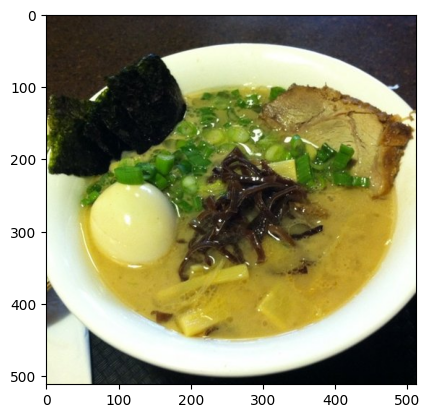

In [9]:
import matplotlib.pyplot as plt

# get a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)
img = Image.open(random_image_path)
plt.imshow(img);

print(f"Image's height : {img.height} , width : {img.width}")

Now that we have seen what data we have , lets convert the data into tensors , then convert into dataset , and then dataloader

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets ,  transforms


In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor() ,# converts all pixel values from 0-255 to be between 0-1
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [12]:
def plot_transformed_images(image_paths , transform , n = 3 , seed = 42):
  """Plots a series of random images from image_paths"""
  random.seed(seed)
  random_image_paths = random.sample(image_paths , k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f: # Use the image_path from the loop
      fig , ax = plt.subplots(1,2)
      ax[0].imshow(f);
      ax[0].set_title(f"Original Image \n Size: {f.size}")
      ax[0].axis("off")

      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image);
      ax[1].set_title(f"Transformed Image \n Size: {tuple(transformed_image.shape)}")
      ax[1].axis(False)
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16);


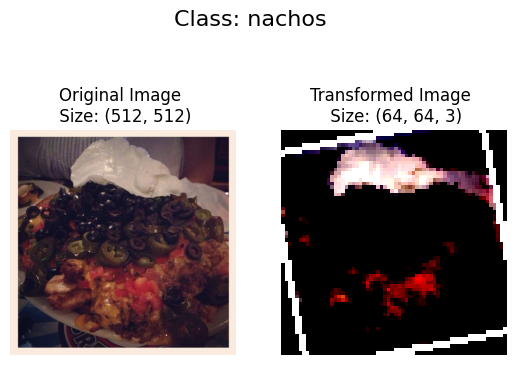

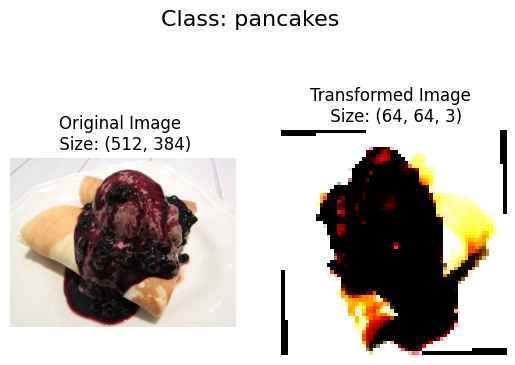

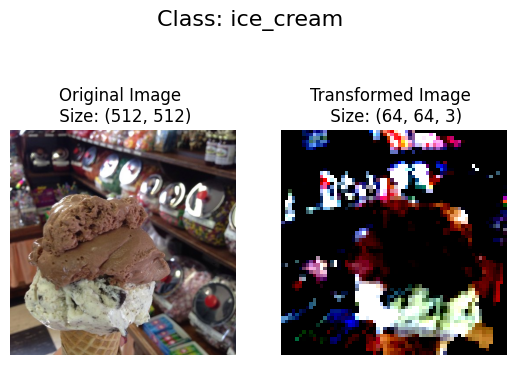

In [13]:
plot_transformed_images(image_path_list , transform = data_transform , n = 3 )

Use ImageFolder to create dataset

In [14]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_dataset = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

train_dataset , test_dataset

(Dataset ImageFolder
     Number of datapoints: 600
     Root location: Data/ic_pancake_ramen_nachos/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: Data/ic_pancake_ramen_nachos/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.22

In [15]:
class_names = train_dataset.classes
class_names

['ice_cream', 'nachos', 'pancakes', 'ramen']

In [16]:
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'ice_cream': 0, 'nachos': 1, 'pancakes': 2, 'ramen': 3}

In [17]:
len(train_dataset) , len(test_dataset)

(600, 200)

Convert into DataLoader

In [18]:
import os
os.cpu_count()

2

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              num_workers = os.cpu_count())

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = False,
                              num_workers = os.cpu_count())

train_dataloader , test_dataloader , len(train_dataloader) , len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x783a328de4b0>,
 19,
 7)

In [20]:
img , label = next(iter(train_dataloader))
print(f"Image shape : {img.shape} : (batch_size , c , h , w)")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([32, 3, 64, 64]) : (batch_size , c , h , w)
Label shape : torch.Size([32])


In [21]:
img

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

create baseline model : model_0

In [22]:
import torch
from torch import nn

class tinyVGG(nn.Module):
  def __init__(self,input_shape , hidden_units , output_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(p=0.4)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(p=0.4)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.4),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)

    )
  def forward(self , x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape : {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape : {x.shape}")
    x = self.classifier(x)
    # print(f"Classifier shape : {x.shape}")
    return x


In [23]:
# dummy data
# dummy_x = torch.rand(size=[1,3,64,64])
# model_0(dummy_x.to(device))

NameError: name 'model_0' is not defined

create training and testing functions

In [25]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               device=device):

  model.train()
  train_loss , train_acc = 0 , 0
  for batch , (X,y) in enumerate(dataloader):
    X,y = X.to(device) , y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred , y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss , train_acc

In [26]:
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               device=device):

  model.eval()
  test_loss , test_acc = 0 , 0
  with torch.inference_mode():
    for batch , (X,y) in enumerate(dataloader):
      X,y = X.to(device) , y.to(device)

      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits , y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(test_pred_logits,dim=1)

      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss , test_acc

In [27]:
from tqdm.auto import tqdm

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs:int = 5,
          device=device):

  results = {
      "train_loss" : [],
      "train_accuracy" : [],
      "test_loss" : [],
      "test_accuracy" : []
  }

  for epoch in tqdm(range(epochs)):
    train_loss , train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

    test_loss , test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)

    print(f"Epoch : {epoch+1} | "
          f"Train loss :{train_loss:.4f} | "
          f"Train Acc : {train_acc:.4f} | "
          f"Test loss : {test_loss:.4f} | "
          f"Test Acc : {test_acc:.4f} | ")

    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

  return results

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = tinyVGG(input_shape = 3,
                  hidden_units = 64,
                  output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(params = model_0.parameters() , lr = 0.001 , weight_decay=1e-3)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=Optimizer,
                        loss_fn = loss_fn,
                        epochs = 20,
                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch : 1 | Train loss :1.4198 | Train Acc : 0.2473 | Test loss : 1.3924 | Test Acc : 0.2411 | 
Epoch : 2 | Train loss :1.3783 | Train Acc : 0.3043 | Test loss : 1.3749 | Test Acc : 0.2589 | 
Epoch : 3 | Train loss :1.3112 | Train Acc : 0.3871 | Test loss : 1.3019 | Test Acc : 0.3482 | 
Epoch : 4 | Train loss :1.2680 | Train Acc : 0.4090 | Test loss : 1.2780 | Test Acc : 0.3661 | 
Epoch : 5 | Train loss :1.2504 | Train Acc : 0.4260 | Test loss : 1.2325 | Test Acc : 0.3929 | 
Epoch : 6 | Train loss :1.2314 | Train Acc : 0.4211 | Test loss : 1.2423 | Test Acc : 0.4018 | 
Epoch : 7 | Train loss :1.2113 | Train Acc : 0.4370 | Test loss : 1.2178 | Test Acc : 0.3884 | 
Epoch : 8 | Train loss :1.2336 | Train Acc : 0.4430 | Test loss : 1.2196 | Test Acc : 0.4196 | 
Epoch : 9 | Train loss :1.1992 | Train Acc : 0.4529 | Test loss : 1.2297 | Test Acc : 0.3795 | 
Epoch : 10 | Train loss :1.1984 | Train Acc : 0.4567 | Test loss : 1.2116 | Test Acc : 0.4196 | 
Epoch : 11 | Train loss :1.1908 | Train

In [31]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results:Dict[str,List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_accuracy"]
  test_accuracy = results["test_accuracy"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs , loss , label = "train_loss")
  plt.plot(epochs , test_loss , label = "train_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs , accuracy , label = "train_acc")
  plt.plot(epochs , test_accuracy , label = "test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

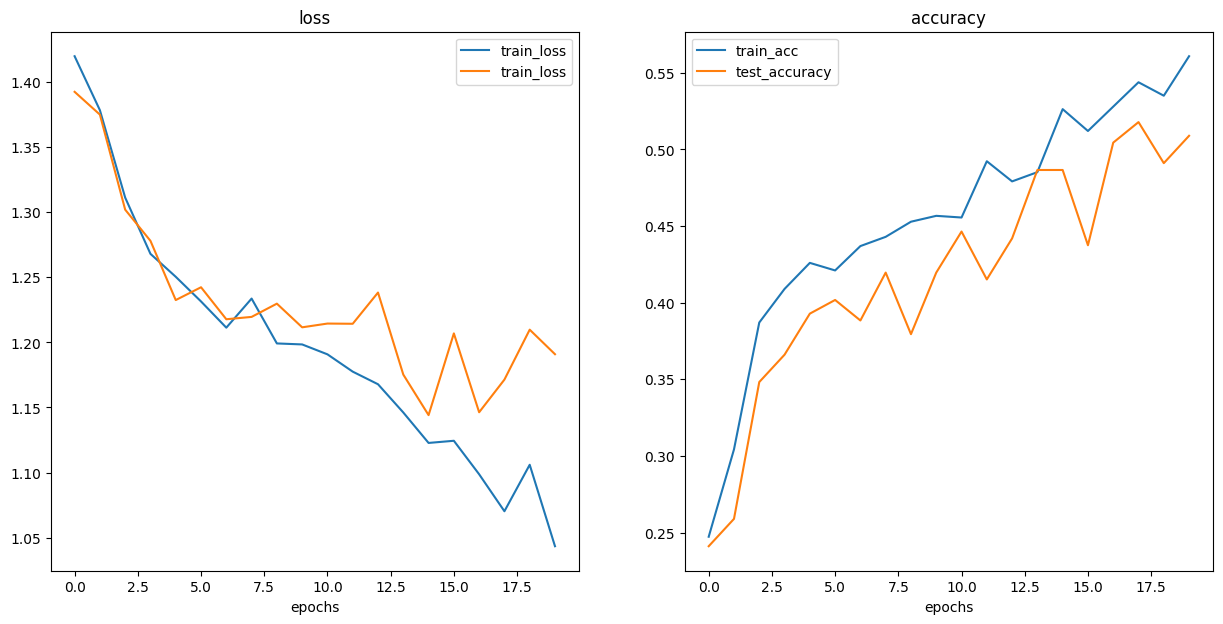

In [32]:
plot_loss_curves(model_0_results)